# Deliverable 1

SNumbers: u264332, u264443, u264202

Names: Levente Olivér Bódi, Riccardo Zamuner, Giada Izzo

## Part 1

In [2]:
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('punkt_tab')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leven\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\leven\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
def preprocess_text(text):
    """
    Preprocess a text by tokenizing, lowercasing, removing stop words, and stemming.
    """
    
    # Tokenize the text into words
    tokens = nltk.word_tokenize(text)

    # Convert to lowercase
    tokens = [token.lower() for token in tokens]

    # Remove punctuation
    tokens = [re.sub(r"[^\w\s]", "", token) for token in tokens]
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove punctuation
    tokens = [re.sub(r"[^\w\s]", "", token) for token in tokens]

    # Stem the tokens
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    # Remove empty strings
    tokens = [token for token in tokens if token]

    return tokens

def clean_seller(text):
    """
    Clean the seller field by removing unwanted trailing phrases.
    """

    # Remove unwanted trailing phrases and everything after them
    remove_phrases = [
        "Seller changed",
        "(Not Enough Ratin",
        "(New Sell"
    ]
    for phrase in remove_phrases:
        idx = text.find(phrase)
        if idx != -1:
            text = text[:idx]
    return text.strip()

def preprocess_non_textual(document):
    """
    Preprocess non-textual fields in the document.
    """

    # Discount preprocessing: convert from string "xx% off" to integer xx
    # also taking into account documents without discount
    if isinstance(document["discount"], str) and "%" in document["discount"]:
        document["discount"] = int(document["discount"][:document["discount"].find("%")])
    else:
        document["discount"] = 0
        
    # Merge all values from product_details dictionary and preprocess
    if isinstance(document["product_details"], dict):
        details_text = " ".join(str(v) for v in document["product_details"].values())
    elif isinstance(document["product_details"], list):
        # If it's a list of dicts, merge all values from all dicts
        details_text = " ".join(str(v) for d in document["product_details"] if isinstance(d, dict) for v in d.values())
    else:
        details_text = str(document["product_details"])
    document["product_details"] = preprocess_text(details_text)

    # Convert actual_price and selling_price to integers (remove commas)
    # If actual_price is NaN, set it to discounted selling_price
    for price_field in ["actual_price", "selling_price"]:
        if isinstance(document[price_field], str):
            price_str = document[price_field].replace(",", "")
            price_val = price_str.split(".")[0]
            document[price_field] = int(price_val) if price_val.isdigit() else 0

    # If actual_price is missing or zero, set it to discounted selling_price
    if ("actual_price" not in document or document["actual_price"] == 0) and "selling_price" in document:
        document["actual_price"] = int(int(document["selling_price"])*document["discount"]/100)

    # Convert average_rating to float, set to NaN if missing or empty
    if "average_rating" in document and str(document["average_rating"]).strip() != "":
        try:
            document["average_rating"] = float(document["average_rating"])
        except ValueError:
            document["average_rating"] = float("nan")
    else:
        document["average_rating"] = float("nan")

    return document

def preprocess_document(document):
    """
    Join all preprocessing steps for a document.
    """

    document["description"] = preprocess_text(document["description"])
    document["title"] = preprocess_text(document["title"])
    document["seller"] = clean_seller(document["seller"])

    document = preprocess_non_textual(document)

    return document


## Section 3

- Pros of Keeping Separate Fields:
Maintaining separate fields allows end users to precisely filter products. If a product’s category, sub-category, or brand exactly matches the user’s filter criteria, it is considered relevant; otherwise, it is excluded.

- Cons of Keeping Separate Fields:
Evaluating overall product relevance across multiple independent fields may require additional computation, especially when considering general or partial relevance.

- Pros of Merging Fields:
Merging all product attributes into a unified representation ensures that every aspect of a product contributes to its overall relevance. For example, if a user performs a general query (rather than a strict filter) involving brands, products from the requested brands will rank higher, while other potentially interesting products may still appear as relevant results.

- Cons of Merging Fields:
This approach removes the ability to apply explicit filters, as all attributes are treated uniformly within the same relevance model.

- A hybrid approach could also work: certain categorical fields might be encoded using one-hot representations and stored in the inverted index structure, allowing a balance between filtering and retrieval depending on how one wants to build their search engine.

Moreover, after conducting exploratory data analysis (EDA), we observed that the dataset contains relatively few distinct categories, sub-categories, and brands. Consequently, merging these fields is unlikely to significantly affect product relevance, as many products share identical values, making their inverse document frequency (IDF) contributions relatively small.

Finally, since product details consist of a mixed array of entries, we concluded that merging all these values into a single representation is the most practical approach. Similar products often share overlapping entries or values, making unified indexing more effective for relevance estimation.

## Section 4
- out_of_stock: boolean. A boolean type is appropriate, as the field can take only two states: in stock or out of stock. It is also useful as a filter to not show any non available products.

- selling_price: numerical. A numerical type allows for efficient range filtering and sorting operations.

- discount: numerical. It could be argued whether to store it as a decimal (i.e. 60% = 0.6) or as a whole number and then remember to divide by 100 when calculating actual price. We choose the second option for no particular reason.

- actual_price: numerical. Same as selling_price.

- average_rating: numerical. A numerical type supports filtering and ranking within retrieval systems.

## Part 2

In [4]:
# Exploratory Data Analysis

# MODIFY THIS PATH AS NEEDED
file_path = "../../data/fashion_products_dataset.json"

with open(file_path, "r") as f:
    data = json.load(f)
    df = pd.DataFrame(data)

print(df.head())


                                    _id actual_price average_rating brand  \
0  fa8e22d6-c0b6-5229-bb9e-ad52eda39a0a        2,999            3.9  York   
1  893e6980-f2a0-531f-b056-34dd63fe912c        1,499            3.9  York   
2  eb4c8eab-8206-59d0-bcd1-a724d96bf74f        2,999            3.9  York   
3  3f3f97bb-5faf-57df-a9ff-1af24e2b1045        2,999            3.9  York   
4  750caa3d-6264-53ca-8ce1-94118a1d8951        2,999            3.9  York   

                   category     crawled_at  \
0  Clothing and Accessories  1612987911000   
1  Clothing and Accessories  1612987912000   
2  Clothing and Accessories  1612987912000   
3  Clothing and Accessories  1612987913000   
4  Clothing and Accessories  1612987913000   

                                         description discount  \
0  Yorker trackpants made from 100% rich combed c...  69% off   
1  Yorker trackpants made from 100% rich combed c...  66% off   
2  Yorker trackpants made from 100% rich combed c...  68% off   


In [5]:
# 1. Overview of missing values (NaN and empty strings)
missing_info = df.isnull().sum()
empty_info = (df == '').sum()
print("\nEmpty string values per column:\n", empty_info)

# 2. Number of unique brands, categories, sub-categories (excluding empty strings)
print("\nUnique brands (excluding empty):", df.loc[df['brand'] != '', 'brand'].nunique())
print("Unique categories (excluding empty):", df.loc[df['category'] != '', 'category'].nunique())
print("Unique sub-categories (excluding empty):", df.loc[df['sub_category'] != '', 'sub_category'].nunique())

# 3. Top 10 brands by product count (excluding empty)
print("\nTop 10 brands by product count:\n", df.loc[df['brand'] != '', 'brand'].value_counts().head(10))

# 4. Distribution of products by category (excluding empty)
print("\nProduct count by category:\n", df.loc[df['category'] != '', 'category'].value_counts())

# 5. Distribution of products by sub-category (top 10, excluding empty)
print("\nTop 10 sub-categories by product count:\n", df.loc[df['sub_category'] != '', 'sub_category'].value_counts().head(10))

# 6. Out of stock ratio
out_of_stock_ratio = df['out_of_stock'].mean()
print(f"\nOut of stock ratio: {out_of_stock_ratio:.2%}")

# 7. Summary statistics for prices and ratings
print("\nSummary statistics for actual_price, selling_price, discount, average_rating:")
print(df[['actual_price', 'selling_price', 'discount', 'average_rating']].describe())


Empty string values per column:
 _id                    0
actual_price         777
average_rating      2261
brand               2009
category               0
crawled_at             0
description        11150
discount             855
images                 0
out_of_stock           0
pid                    0
product_details        0
seller              1643
selling_price          2
sub_category           0
title                  0
url                    0
dtype: int64

Unique brands (excluding empty): 324
Unique categories (excluding empty): 4
Unique sub-categories (excluding empty): 24

Top 10 brands by product count:
 brand
ECKO Unl        951
Free Authori    860
ARBO            806
REEB            802
Pu              798
True Bl         793
Keo             660
Amp             585
Black Beat      548
vims rai        503
Name: count, dtype: int64

Product count by category:
 category
Clothing and Accessories    27118
Footwear                      920
Bags, Wallets & Belts          41
T

In [6]:
# Find products with empty selling_price, actual_price, or discount
empty_prices = df[(df['selling_price'] == '') | (df['actual_price'] == '') | (df['discount'] == '')]

# Print the number of such products
print(f"Number of products with empty selling_price, actual_price, or discount: {len(empty_prices)}")

# Show a few examples
print(empty_prices[['title', 'brand', 'selling_price', 'actual_price', 'discount']].sample(10))

Number of products with empty selling_price, actual_price, or discount: 855
                                               title             brand  \
15893           Printed Men Round Neck Black T-Shirt  HUMANITY ORIGINA   
8091          Women Regular Fit Printed Casual Shirt                 V   
8377                                    Women Trunks                 V   
3730   Amaze Football Shoes For Women  (Green, Blue)            Vector   
16023     Graphic Print Men Round Neck Black T-Shirt  HUMANITY ORIGINA   
15907         Printed Women Round Neck Black T-Shirt  HUMANITY ORIGINA   
8390                                    Women Trunks                 V   
8063                        Women Brief  (Pack of 6)                 V   
2832                Solid Men Polo Neck Blue T-Shirt              AXMA   
15996     Graphic Print Men Round Neck Black T-Shirt  HUMANITY ORIGINA   

      selling_price actual_price discount  
15893           699                        
8091            999  

In [7]:
def impute_actual_price(row):
    # if actual_price is empty, try to compute it:
    # either from selling_price and discount, or just use selling_price
    if row['actual_price'] == '':
        # Convert selling_price and discount to float if not empty
        if row['selling_price'] != '' and row['discount'] != '':
            selling_price = float(str(row['selling_price']).replace(',', ''))
            discount = float(str(row['discount']).replace('%', '').replace('off', '').strip())
            return selling_price * (1 - discount / 100)
        elif row['selling_price'] != '':
            return float(str(row['selling_price']).replace(',', ''))
    return row['actual_price']

df['discount'] = df['discount'].replace('', '0')
df['actual_price'] = df.apply(impute_actual_price, axis=1)
# Check for empty strings in each column
empty_info = (df == '').sum()
print("Empty string values per column:\n", empty_info)

Empty string values per column:
 _id                    0
actual_price           2
average_rating      2261
brand               2009
category               0
crawled_at             0
description        11150
discount               0
images                 0
out_of_stock           0
pid                    0
product_details        0
seller              1643
selling_price          2
sub_category           0
title                  0
url                    0
dtype: int64


In [8]:
# Drop the remaining products without price
df = df[(df['actual_price'] != '') & (df['selling_price'] != '')]
print("Empty string values per column:\n", (df == '').sum())

Empty string values per column:
 _id                    0
actual_price           0
average_rating      2259
brand               2009
category               0
crawled_at             0
description        11149
discount               0
images                 0
out_of_stock           0
pid                    0
product_details        0
seller              1641
selling_price          0
sub_category           0
title                  0
url                    0
dtype: int64


In [9]:
# Replace empty brand names with 'no brand'
df.loc[df['brand'] == '', 'brand'] = 'no brand'

We have done some data cleaning, there are still some products that do not have average rating. For the moment we are just keeping those values, we will decide later what to do with this values. Besides, we could drop crawled_at and images, but for now we keep them.

In [10]:
# Print 5 random entries from the dataset
df = df.apply(preprocess_document, axis=1)
print(df.sample(5))

                                        _id  actual_price  average_rating  \
16894  c3410255-4db7-5919-9cc7-01f6595c477c         849.0             4.1   
16633  0a42c1b5-e1ba-5d4a-96e9-d3d8ecb4b8df         849.0             4.0   
24485  e0cbe5b9-b661-5f77-b840-ea9c8569b326        1799.0             4.7   
13796  6a414c02-473c-5855-b15c-00f0e3b2e465         799.0             3.8   
17609  375122c3-44bc-5ef8-8165-3c8173ed5097         699.0             4.7   

                   brand                  category     crawled_at  \
16894         Black Beat                  Footwear  1612999843000   
16633         Black Beat                  Footwear  1612999662000   
24485               SORA  Clothing and Accessories  1613004905000   
13796  Scott Internation  Clothing and Accessories  1612997831000   
17609               Cots  Clothing and Accessories  1613000323000   

                                             description  discount  \
16894                                               

c:\Users\leven\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


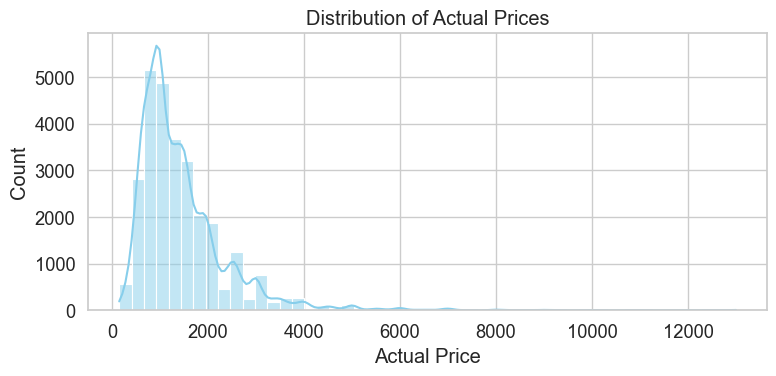

1442.791651827053


c:\Users\leven\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


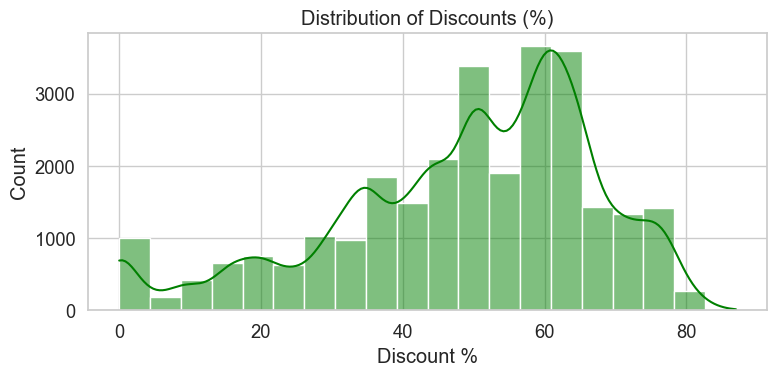

c:\Users\leven\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


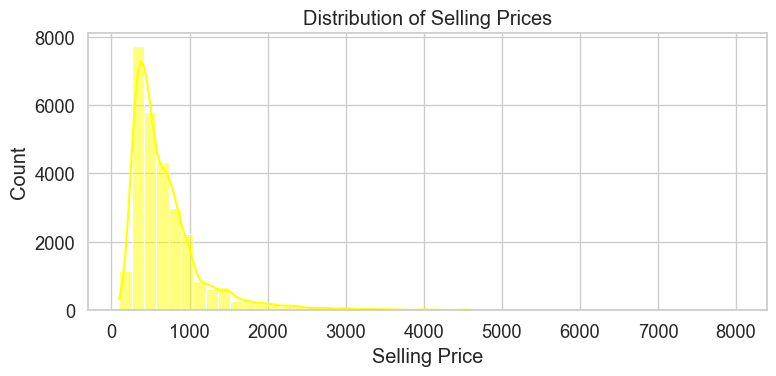

705.6350879692286


c:\Users\leven\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


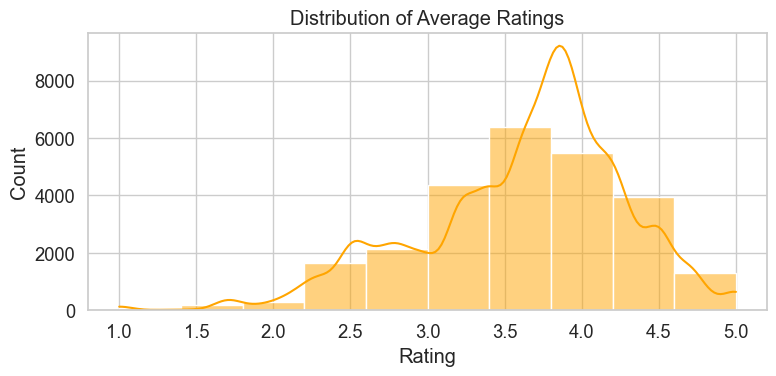

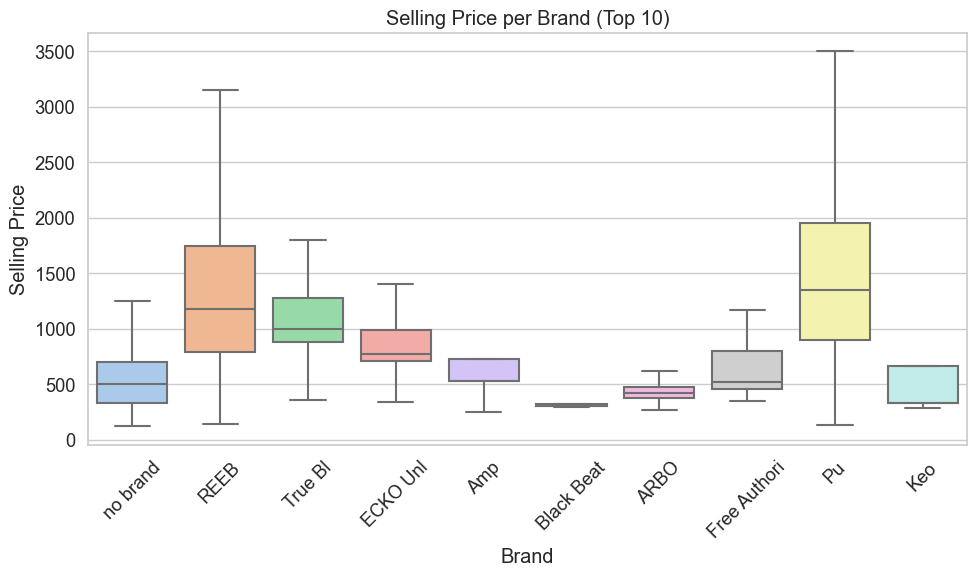

In [11]:
# Set a nicer style
sns.set(style="whitegrid", palette="pastel", font_scale=1.2)

# Actual Price Distribution
plt.figure(figsize=(8, 4))
sns.histplot(df["actual_price"], bins=50, kde=True, color="skyblue")
plt.title("Distribution of Actual Prices")
plt.xlabel("Actual Price")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
print(np.mean(df["actual_price"]))

# Discounts Distribution
plt.figure(figsize=(8, 4))
sns.histplot(df["discount"], bins=20, kde=True, color="green")
plt.title("Distribution of Discounts (%)")
plt.xlabel("Discount %")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Selling Price Distribution
plt.figure(figsize=(8, 4))
sns.histplot(df["selling_price"], bins=50, kde=True, color="yellow")
plt.title("Distribution of Selling Prices")
plt.xlabel("Selling Price")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
print(np.mean(df["selling_price"]))

# Ratings Distribution
plt.figure(figsize=(8, 4))
sns.histplot(df["average_rating"], bins=10, kde=True, color="orange")
plt.title("Distribution of Average Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


# Selling price per brand (top 10 brands)
top_brands = df["brand"].value_counts().head(10).index
plt.figure(figsize=(10, 6))
sns.boxplot(x="brand", y="selling_price", data=df[df["brand"].isin(top_brands)], showfliers=False)
plt.title("Selling Price per Brand (Top 10)")
plt.xlabel("Brand")
plt.ylabel("Selling Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Total words: 521327
Vocabulary size: 5568
Average sentence length: 18.567098796210555

Top 5 products by rating:
                                                   title  average_rating
12339  [graphic, print, women, round, neck, white, ts...             5.0
12334    [print, solid, men, round, neck, black, tshirt]             5.0
12348   [solid, women, round, neck, black, grey, tshirt]             5.0
27767          [solid, women, round, neck, blue, tshirt]             5.0
19971   [regular, fit, men, grey, satin, blend, trouser]             5.0

Top 5 cheapest products:
                                              title  selling_price
20435                         [men, print, bandana]             99
16485                 [women, midcalfcrew, pack, 2]             99
7654   [women, color, block, ankl, length, pack, 3]            118
24437         [women, solid, ankl, length, pack, 3]            120
24439         [women, solid, ankl, length, pack, 3]            120

Top 5 products by di

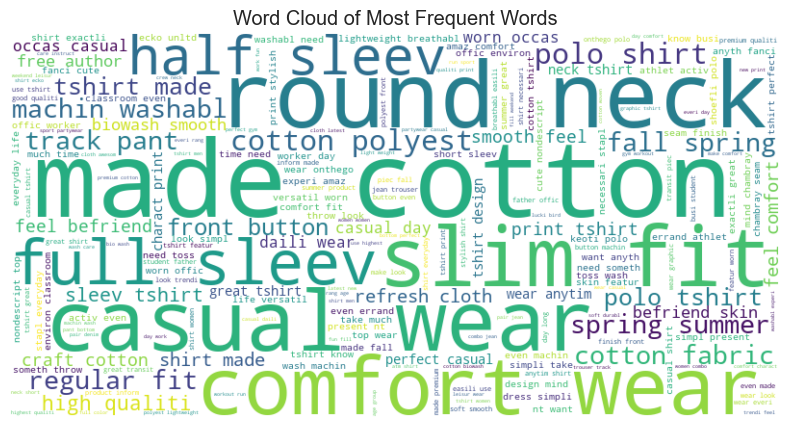

In [23]:
# 1. Word counting, average sentence length, vocabulary size
all_text = " ".join(df["description"].astype(str).tolist())
# Use a simple regex-based tokenizer instead of nltk.word_tokenize
words = re.findall(r'\b\w+\b', all_text.lower())
vocab = set(words)
print("Total words:", len(words))
print("Vocabulary size:", len(vocab))
print("Average sentence length:", np.mean([len(re.findall(r'\b\w+\b', s.lower())) for s in df["description"].astype(str).tolist()]))

# 2. Ranking of products based on rating, price, discount
print("\nTop 5 products by rating:")
print(df.sort_values("average_rating", ascending=False)[["title", "average_rating"]].head())

print("\nTop 5 cheapest products:")
print(df.sort_values("selling_price")[["title", "selling_price"]].head())

print("\nTop 5 products by discount:")
print(df.sort_values("discount", ascending=False)[["title", "discount"]].head())

# 3. Top sellers and brands
print("\nTop 5 sellers:")
print(df["seller"].value_counts().head())

print("\nTop 5 brands:")
print(df["brand"].value_counts().head())

# 4. Word cloud for most frequent words
filtered_words = [w.lower() for w in words if w.isalpha() and w.lower() not in stopwords.words('english')]
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(filtered_words))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Most Frequent Words")
plt.show()


# Deliverable 2

## Part 1

### Build index

In [13]:
from collections import defaultdict

def normalize_cat_token(val):
    if pd.isna(val) or str(val).strip() == "":
        return []
    # split common multi-value strings; keep a single value as 1-item list
    parts = re.split(r"[\/,;|]", str(val))
    return [re.sub(r"\s+", "_", p.strip().lower()) for p in parts if p.strip()]

In [25]:
print(df.columns)

Index(['_id', 'actual_price', 'average_rating', 'brand', 'category',
       'crawled_at', 'description', 'discount', 'images', 'out_of_stock',
       'pid', 'product_details', 'seller', 'selling_price', 'sub_category',
       'title', 'url'],
      dtype='object')


In [ ]:
def build_inverted_index_df(df: pd.DataFrame,id_col: str | None = None,text_cols: list[str] = ("title", "description", "product_details"),min_df: int = 1,store_positions: bool = False):
    """
    df: preprocessed dataframe (title/description/product_details are token lists).
    id_col: column holding unique ids; if None, uses df.index (as str).
    text_cols: columns with *token lists* (already stemmed, stopwords removed).
    min_df: drop terms that appear in < min_df documents.
    store_positions: if True, also keep term positions for phrase/proximity queries.
    """
    # assign doc ID's
    doc_ids = df[id_col].astype(str).tolist() if id_col else df.index.astype(str).tolist()

    per_doc_terms = []
    per_doc_sequence = []

    # gather tokens for each row
    for _, row in df.iterrows():
        tokens = []

        # text cols are already tokenized lists after preprocess_document(), we just make it robust if something slipped through
        for c in text_cols:
            if c in df.columns:
                vals = row[c]
                if isinstance(vals, (list, tuple)):
                    tokens.extend([str(t).lower() for t in vals if str(t).strip()])
                elif pd.notna(vals):
                    # if something slipped through as string, tokenize lightly:
                    tokens.extend(re.findall(r"[A-Za-z0-9]+", str(vals).lower()))




        # ensure we have a sequence for positions and a set for boolean presence
        if store_positions:
            per_doc_sequence.append(tokens[:])
        per_doc_terms.append(set(tokens))

    # build postings (term -> list[doc_id]) and df counts
    postings_tmp = defaultdict(list)
    df_count = defaultdict(int)

    for d_i, terms in enumerate(per_doc_terms):
        did = doc_ids[d_i]
        for term in terms:
            postings_tmp[term].append(did)
            df_count[term] += 1

    # min_df filter + sort postings
    postings_tmp = {t: sorted(dids) for t, dids in postings_tmp.items() if df_count[t] >= min_df}

    # vocab
    vocab = {term: tid for tid, term in enumerate(sorted(postings_tmp.keys()))}
    id2term = {tid: term for term, tid in vocab.items()}

    # final inverted index (term_id -> [doc_ids])
    inv_index = {vocab[t]: dids for t, dids in postings_tmp.items()}

    # positional index
    positional = None
    if store_positions:
        positional = {tid: defaultdict(list) for tid in inv_index.keys()}
        for d_i, seq in enumerate(per_doc_sequence):
            did = doc_ids[d_i]
            for pos, tok in enumerate(seq):
                if tok in vocab:
                    tid = vocab[tok]
                    positional[tid][did].append(pos)
        # convert inner dicts to normal dicts
        positional = {tid: dict(dmap) for tid, dmap in positional.items()}

    return {
        "vocab": vocab,            # term -> term_id
        "id2term": id2term,        # term_id -> term
        "postings": inv_index,     # term_id -> [doc_id, ...] (sorted)
        "doc_ids": doc_ids,        # all doc ids, as strings
        "positional": positional   # optional: term_id -> {doc_id: [positions]}
    }

index_obj = build_inverted_index_df(
    df,
    id_col=None,
    text_cols=df.columns,
    min_df=1,
    store_positions=False
)

In [ ]:
# Quick lookups
def docs_for_term(term: str):
    """Return document IDs for a raw term or categorical token (e.g., 'brand:nike')."""
    tid = index_obj["vocab"].get(term)
    return index_obj["postings"].get(tid, []) if tid is not None else []

def and_query(terms: list[str]):
    """Boolean AND over terms."""
    sets = [set(docs_for_term(t)) for t in terms]
    return sorted(set.intersection(*sets)) if sets else []

def or_query(terms: list[str]):
    """Boolean OR over terms."""
    s = set()
    for t in terms:
        s.update(docs_for_term(t))
    return sorted(s)


# Plain term from text columns (remember: your text is stemmed, e.g., 'cotton' -> 'cotton')
print("docs for 'cotton':", docs_for_term("cotton"))


print("docs for nike:", docs_for_term("nike"))
print("docs for category tshirts:", docs_for_term("tshirts"))
print("cotton AND nike:", and_query(["cotton", "nike"]))
print("hoodi OR sweatshir:", or_query(["hoodi", "sweatshir"]))

# Numeric test
print("docs for 50", docs_for_term("50"))

docs for 'cotton': ['0', '1', '10', '1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '10099', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '10221', '10222', '10223', '10227', '10230', '10234', '10237', '10238', '10239', '10241', '10242', '10243', '10245', '10246', '10248', '10249', '1025', '10250', '10252', '10253', '10256', '10257', '1026', '10264', '10266', '10268', '1027', '10276', '10278', '1028', '10280', '10281', '10283', '10285', '10294', '10295', '10298', '10299', '10304', '10306', '10307', '10309', '1031', '10310', '10311', '10313', '10314', '10316', '10317', '10318', '10321', '10322', '10323', '10324', '10325', '10326', '10327', '10328', '10330', '10333', '10334', '10335', '10336', '10337', '10338', '10340', '10341', '10342', '10343', '10345', '10346', '10347', '10348', '10349', '1035', '10350', '10351', '10352', '10353', '10354', '10357', '10359', '10360', '10361', '10363', '10364', '10365', '10367', '10368', '10370', '10371', '10372

### Example queries

In [40]:
from collections import Counter

all_terms = [term for tokens in df["description"] for term in tokens]
term_freq = Counter(all_terms)
print(term_freq.most_common(20))


test_queries = {
    "Q1": ["cotton", "tshirt", "50", "100", "men", "blue"],
    "Q2": ["nike", "hoodi"],
    "Q3": ["denim", "jean", "skinny"],
    "Q4": ["dress", "red"],
    "Q5": ["leather", "jacket"]  # then post-filter results with df['discount'] > 50
}

for qid, terms in test_queries.items():
    result_docs = and_query(terms)
    print(f"{qid} -> {len(result_docs)} results: {result_docs[:10]}")


[('tshirt', 12385), ('cotton', 9944), ('wear', 9250), ('comfort', 8654), ('shirt', 7493), ('look', 6173), ('casual', 5926), ('fit', 5600), ('made', 5591), ('fabric', 5438), ('print', 4870), ('women', 4416), ('design', 4237), ('sleev', 4009), ('qualiti', 4002), ('men', 3731), ('day', 3463), ('wash', 3453), ('style', 3241), ('make', 3233)]
Q1 -> 30 results: ['11237', '11276', '11278', '19230', '19252', '19427', '19461', '20373', '23364', '23524']
Q2 -> 0 results: []
Q3 -> 68 results: ['11502', '11513', '11527', '11580', '11596', '11628', '11629', '11637', '11648', '11657']
Q4 -> 62 results: ['120', '122', '126', '134', '14264', '149', '17411', '23788', '26308', '26884']
Q5 -> 56 results: ['1018', '1029', '1030', '10344', '1040', '1041', '1126', '13175', '14094', '14170']


### Build TF-IDF Ranking